Mostly coppied from https://github.com/lsst/rubin_scheduler/blob/main/rubin_scheduler/scheduler/surveys/ddf_presched.py

Using `rubin_scheduler`, should be able to install everything needed with:

    conda install -c conda-forge rubin-scheduler
    scheduler_download_data

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import os

from rubin_scheduler.data import get_data_dir
from rubin_scheduler.scheduler.utils import scheduled_observation
from rubin_scheduler.utils import calc_season, ddf_locations, survey_start_mjd
from rubin_scheduler.site_models import Almanac

from scipy.stats import binned_statistic

from astropy.time import Time

In [2]:
# Data file containing handy depths over time for each DDF location. 
# This gets downloaded with the scheduler_download_data command.
data_file = os.path.join(get_data_dir(), "scheduler", "ddf_grid.npz")
ddf_data = np.load(data_file)
ddf_grid = ddf_data["ddf_grid"].copy()
ddf_data.close()

# Load up the locations of the DDFs
ddfs = ddf_locations()
ddfs

{'ELAISS1': (9.45, -44.0),
 'XMM_LSS': (35.708333, -4.75),
 'ECDFS': (53.125, -28.1),
 'COSMOS': (150.1, 2.1819444444444445),
 'EDFS_a': (58.9, -49.315),
 'EDFS_b': (63.6, -47.6)}

In [3]:
print(ddf_grid)

[(59560.2       , -0.63878697, 59560.332126  , 1.87806462, 20.37530221, 23.4043996 , 1.58073154, 20.33989545, 23.5628207 , 1.10840085, 20.96069667, 24.19286477, 3.24779407,         nan,         nan, 1.11290969, 21.08211498, 24.24670622, 1.08282637, 21.1223122 , 24.28990426)
 (59560.21041667, -0.63346487, 59560.33213486, 2.02792796, 20.60595477, 23.43391248, 1.69409615, 20.58254611, 23.61090083, 1.14108744, 21.16347017, 24.26270774, 2.78094257, 20.44678077, 22.99102926, 1.13285313, 21.28566312, 24.32635956, 1.0988619 , 21.32615497, 24.37229843)
 (59560.22083333, -0.62399475, 59560.33212362, 2.20678149, 20.8097976 , 23.43852339, 1.83287789, 20.81070785, 23.63951929, 1.17957691, 21.35335944, 24.3215756 , 2.44111724, 20.73522971, 23.2872046 , 1.15640057, 21.46854152, 24.39269844, 1.1182692 , 21.50565488, 24.43972994)
 ...
 (74170.1687466 , -0.62909172, 74170.3321128 , 1.55714723, 22.03527819, 24.36829291, 1.34952862, 22.01523636, 24.49696015, 1.04068958, 22.29501426, 24.85244401, 6.6737447

In [4]:
# Can see the grid has MJD, and then airmass, sky brightness, amd g-band 5-sigma limiting depth per ddf
# Note the depth is assuming some nominal constant seeing (probably 0.7 arcsec at zenith)
# Also the sun altitude at each timestep, as well as the next sunrise twilight start.
ddf_grid.dtype

dtype([('mjd', '<f8'), ('sun_alt', '<f8'), ('sun_n18_rising_next', '<f8'), ('ELAISS1_airmass', '<f8'), ('ELAISS1_sky_g', '<f8'), ('ELAISS1_m5_g', '<f8'), ('XMM_LSS_airmass', '<f8'), ('XMM_LSS_sky_g', '<f8'), ('XMM_LSS_m5_g', '<f8'), ('ECDFS_airmass', '<f8'), ('ECDFS_sky_g', '<f8'), ('ECDFS_m5_g', '<f8'), ('COSMOS_airmass', '<f8'), ('COSMOS_sky_g', '<f8'), ('COSMOS_m5_g', '<f8'), ('EDFS_a_airmass', '<f8'), ('EDFS_a_sky_g', '<f8'), ('EDFS_a_m5_g', '<f8'), ('EDFS_b_airmass', '<f8'), ('EDFS_b_sky_g', '<f8'), ('EDFS_b_m5_g', '<f8')])

In [5]:
mjd_start = survey_start_mjd()
print("survey start: MJD",mjd_start,"= UT",Time(mjd_start,format='mjd').iso)

survey start: MJD 60796.0 = UT 2025-05-01 00:00:00.000


In [6]:
ddf_name = "XMM_LSS"
season_start_offset = 15
season_end_offset = 330

# don't need to edit these
long_m5_limit = 23.0
short_m5_limit = 24.0
n_high_cadence = 43

Text(0, 0.5, '5-sigma depth in g')

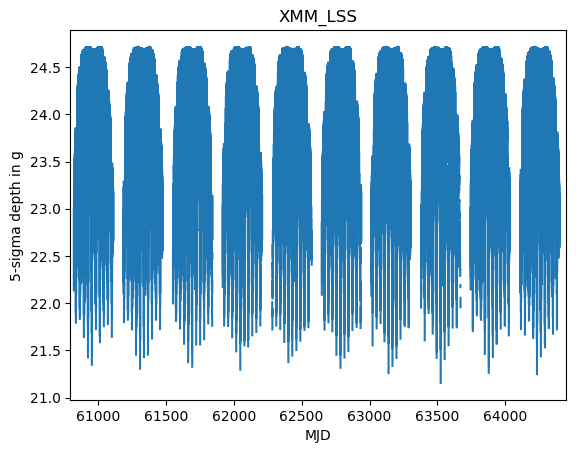

In [7]:
# Let's look at the depths over time for one DDF
fig, ax = plt.subplots()

ax.plot(ddf_grid["mjd"], ddf_grid["%s_m5_g" % ddf_name],'-')
ax.set_xlim([mjd_start,mjd_start+3653])
ax.set_xlabel("MJD")
ax.set_title(ddf_name)
ax.set_ylabel('5-sigma depth in g')

In [8]:
# assign an integer night to each MJD value
almanac = Almanac(mjd_start=survey_start_mjd())
almanac_indx = almanac.mjd_indx(ddf_grid["mjd"])
night = almanac.sunsets["night"][almanac_indx]

# Let's cut down the DDF array to only be 1 years long
indx = np.where((night >= season_start_offset) & (night < season_end_offset))
night = night[indx]
ddf_grid = ddf_grid[indx]

# Let's say we want to observe every night where the depth is
# above some floor.
m5_limit = long_m5_limit
bins = np.arange(np.min(night), np.max(night)+2, 1) - 0.5
finite_indx = np.isfinite(ddf_grid["%s_m5_g" % ddf_name])
deepest_per_night, bin_edges, bin_n = binned_statistic(night[finite_indx],
                                                       ddf_grid["%s_m5_g" % ddf_name][finite_indx],
                                                       statistic=np.nanmax,
                                                       bins=bins)
binned_night = (bin_edges[0:-1] + bin_edges[1:])/2
nights_flag = np.zeros(binned_night.size)
# Loop over each night. If we meet the depth limit, mark it as a night to do a sequence
for i in np.arange(binned_night.size-1)+1:
    if (deepest_per_night[i] > m5_limit):
        nights_flag[i] = 1

nights_to_observe = binned_night[np.where(nights_flag == 1)]

# Could replace the above with any sort of logic you want for which nights 
# You want to observe a DDF


In [9]:

# Some basic limits.  See help(scheduled_observation) for details on these
flush_length = 2. # Days
expt = 30.  # Seconds
mjd_tol = 0.1 # Days
dist_tol = np.radians(2.)
HA_min = 21.  # Hour angle limits
HA_max = 3.
alt_min = np.radians(25.)
alt_max = np.radians(85.)
sun_alt_max = np.radians(-18.)

# How many visits to take in each filter
sequence = {'u':8, 'g': 10, 'r': 20, 'i': 20, 'z': 24, 'y': 18}
# number of snaps per visit
nsnaps = {'u':1, 'g': 1, 'r': 1, 'i': 1, 'z': 1, 'y': 1}

# now to loop over each night and generate a sequence of scheduled observations
final_observations_list = []
for obs_night in nights_to_observe:
    in_night = np.where((night == obs_night) & (np.isfinite(ddf_grid["%s_m5_g" % ddf_name]) == True))[0]
    # find the best time in the night to launch the DDF
    # This could be made more sophisticated, e.g., check there's enough time to do the sequence,
    # or inerpolate to the best time rather than using the nearest timestep, etc.
    indx = np.min(np.where(ddf_grid["%s_m5_g" % ddf_name][in_night] == np.max(ddf_grid["%s_m5_g" % ddf_name][in_night])))
    mjd = ddf_grid["mjd"][in_night[indx]]
    
    for filtername in sequence:
        for i in np.arange(sequence[filtername]):
            # Make a new empty observation
            obs = scheduled_observation()
            # fill in all the relevant info for it
            obs["RA"] = np.radians(ddfs[ddf_name][0])
            obs["dec"] = np.radians(ddfs[ddf_name][1])
            obs["mjd"] = mjd
            obs["flush_by_mjd"] = mjd + flush_length
            obs["exptime"] = expt
            obs["filter"] = filtername
            obs["nexp"] = nsnaps[filtername]
            obs["note"] = "DD:%s" % ddf_name
            obs["target"] = ddf_name

            obs["mjd_tol"] = mjd_tol
            obs["dist_tol"] = dist_tol
            # Need to set something for HA limits
            obs["HA_min"] = HA_min
            obs["HA_max"] = HA_max
            obs["alt_min"] = alt_min
            obs["alt_max"] = alt_max
            obs["sun_alt_max"] = sun_alt_max
            final_observations_list.append(obs)
                        
final_observations = np.concatenate(final_observations_list)
print()
print("season length",np.max(final_observations["mjd"]) - np.min(final_observations["mjd"]),"days")

final_observations


season length 290.58333326567663 days


array([(0, 0.62322798, -0.08290314, 60822.42916637, 60824.42916637, 30., 'u', 0., 0., 0., 0., 1, 'DD:XMM_LSS', 'XMM_LSS', 0.1, 0.03490659, 0.43633231, 1.48352986, 3., 21., -0.31415927, False, 0),
       (0, 0.62322798, -0.08290314, 60822.42916637, 60824.42916637, 30., 'u', 0., 0., 0., 0., 1, 'DD:XMM_LSS', 'XMM_LSS', 0.1, 0.03490659, 0.43633231, 1.48352986, 3., 21., -0.31415927, False, 0),
       (0, 0.62322798, -0.08290314, 60822.42916637, 60824.42916637, 30., 'u', 0., 0., 0., 0., 1, 'DD:XMM_LSS', 'XMM_LSS', 0.1, 0.03490659, 0.43633231, 1.48352986, 3., 21., -0.31415927, False, 0),
       ...,
       (0, 0.62322798, -0.08290314, 61113.01249964, 61115.01249964, 30., 'y', 0., 0., 0., 0., 1, 'DD:XMM_LSS', 'XMM_LSS', 0.1, 0.03490659, 0.43633231, 1.48352986, 3., 21., -0.31415927, False, 0),
       (0, 0.62322798, -0.08290314, 61113.01249964, 61115.01249964, 30., 'y', 0., 0., 0., 0., 1, 'DD:XMM_LSS', 'XMM_LSS', 0.1, 0.03490659, 0.43633231, 1.48352986, 3., 21., -0.31415927, False, 0),
       (

This array can be passed into the scheduler and simulated.

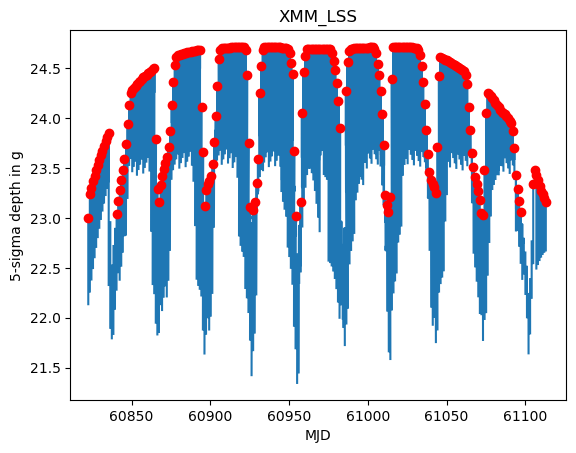

In [10]:
# Let's plot up where the final scheduled results actually landed:
final_mjd = np.unique(final_observations["mjd"])
depths = np.interp(final_mjd, ddf_grid["mjd"], ddf_grid["%s_m5_g" % ddf_name])

fig, ax = plt.subplots()

ax.plot(ddf_grid["mjd"], ddf_grid["%s_m5_g" % ddf_name])
ax.set_xlim([mjd_start+season_start_offset,mjd_start+season_end_offset])
ax.set_xlabel("MJD")
ax.set_title(ddf_name)
ax.set_ylabel('5-sigma depth in g')

ax.plot(final_mjd, depths, 'ro')
long_mjd = final_mjd.copy()
long_depths = depths.copy()

In [11]:
print('MJD midpoint: ',(final_mjd[-1] + final_mjd[0])/2.0)
print('season length: ',final_mjd[-1] - final_mjd[0])
print('MJD start: ',final_mjd[0])
print('MJD end:   ',final_mjd[-1])
print(' ')
print('number:',len(final_mjd))
print(final_mjd)

MJD midpoint:  60967.72083300562
season length:  290.58333326567663
MJD start:  60822.42916637278
MJD end:    61113.012499638455
 
number: 275
[60822.42916637 60823.41874971 60824.41874971 60825.41874971
 60826.41874971 60827.4187497  60828.4187497  60829.4187497
 60830.4187497  60831.42916637 60832.42916637 60833.42916637
 60834.42916637 60835.42916637 60840.42916637 60841.42916637
 60842.42916637 60843.42916637 60844.42916637 60845.42916637
 60846.42916637 60847.42916637 60848.42916637 60849.42916637
 60850.42916637 60851.42916637 60852.42916637 60853.42916637
 60854.42916637 60855.42916637 60856.42916636 60857.42916636
 60858.42916636 60859.42916636 60860.42916636 60861.42916636
 60862.42916636 60863.42916636 60864.42916636 60865.43958303
 60866.43958303 60867.43958303 60868.42916636 60869.42916636
 60870.42916636 60871.42916636 60872.42916636 60873.42916636
 60874.42916636 60875.42916636 60876.41874969 60877.41874969
 60878.41874969 60879.41874969 60880.41874969 60881.41874969
 608

In [12]:
# Let's say we want to observe every night where the depth is
# above some floor.
m5_limit = short_m5_limit
bins = np.arange(np.min(night), np.max(night)+2, 1) - 0.5
finite_indx = np.isfinite(ddf_grid["%s_m5_g" % ddf_name])
deepest_per_night, bin_edges, bin_n = binned_statistic(night[finite_indx],
                                                       ddf_grid["%s_m5_g" % ddf_name][finite_indx],
                                                       statistic=np.nanmax,
                                                       bins=bins)
binned_night = (bin_edges[0:-1] + bin_edges[1:])/2
nights_flag = np.zeros(binned_night.size)
# Loop over each night. If we meet the depth limit, mark it as a night to do a sequence
for i in np.arange(binned_night.size-1)+1:
    if (deepest_per_night[i] > m5_limit):
        nights_flag[i] = 1

nights_to_observe = binned_night[np.where(nights_flag == 1)]

# Could replace the above with any sort of logic you want for which nights 
# You want to observe a DDF


In [13]:

# Some basic limits.  See help(scheduled_observation) for details on these
flush_length = 2. # Days
expt = 30.  # Seconds
mjd_tol = 0.1 # Days
dist_tol = np.radians(2.)
HA_min = 21.  # Hour angle limits
HA_max = 3.
alt_min = np.radians(25.)
alt_max = np.radians(85.)
sun_alt_max = np.radians(-18.)

# How many visits to take in each filter
sequence = {'u':8, 'g': 10, 'r': 20, 'i': 20, 'z': 24, 'y': 18}
# number of snaps per visit
nsnaps = {'u':1, 'g': 1, 'r': 1, 'i': 1, 'z': 1, 'y': 1}

# now to loop over each night and generate a sequence of scheduled observations
final_observations_list = []
for obs_night in nights_to_observe:
    in_night = np.where((night == obs_night) & (np.isfinite(ddf_grid["%s_m5_g" % ddf_name]) == True))[0]
    # find the best time in the night to launch the DDF
    # This could be made more sophisticated, e.g., check there's enough time to do the sequence,
    # or inerpolate to the best time rather than using the nearest timestep, etc.
    indx = np.min(np.where(ddf_grid["%s_m5_g" % ddf_name][in_night] == np.max(ddf_grid["%s_m5_g" % ddf_name][in_night])))
    mjd = ddf_grid["mjd"][in_night[indx]]
    
    for filtername in sequence:
        for i in np.arange(sequence[filtername]):
            # Make a new empty observation
            obs = scheduled_observation()
            # fill in all the relevant info for it
            obs["RA"] = np.radians(ddfs[ddf_name][0])
            obs["dec"] = np.radians(ddfs[ddf_name][1])
            obs["mjd"] = mjd
            obs["flush_by_mjd"] = mjd + flush_length
            obs["exptime"] = expt
            obs["filter"] = filtername
            obs["nexp"] = nsnaps[filtername]
            obs["note"] = "DD:%s" % ddf_name
            obs["target"] = ddf_name

            obs["mjd_tol"] = mjd_tol
            obs["dist_tol"] = dist_tol
            # Need to set something for HA limits
            obs["HA_min"] = HA_min
            obs["HA_max"] = HA_max
            obs["alt_min"] = alt_min
            obs["alt_max"] = alt_max
            obs["sun_alt_max"] = sun_alt_max
            final_observations_list.append(obs)
                        
final_observations = np.concatenate(final_observations_list)
print()
print("season length",np.max(final_observations["mjd"]) - np.min(final_observations["mjd"]),"days")

final_observations


season length 239.60416661087947 days


array([(0, 0.62322798, -0.08290314, 60848.42916637, 60850.42916637, 30., 'u', 0., 0., 0., 0., 1, 'DD:XMM_LSS', 'XMM_LSS', 0.1, 0.03490659, 0.43633231, 1.48352986, 3., 21., -0.31415927, False, 0),
       (0, 0.62322798, -0.08290314, 60848.42916637, 60850.42916637, 30., 'u', 0., 0., 0., 0., 1, 'DD:XMM_LSS', 'XMM_LSS', 0.1, 0.03490659, 0.43633231, 1.48352986, 3., 21., -0.31415927, False, 0),
       (0, 0.62322798, -0.08290314, 60848.42916637, 60850.42916637, 30., 'u', 0., 0., 0., 0., 1, 'DD:XMM_LSS', 'XMM_LSS', 0.1, 0.03490659, 0.43633231, 1.48352986, 3., 21., -0.31415927, False, 0),
       ...,
       (0, 0.62322798, -0.08290314, 61088.03333298, 61090.03333298, 30., 'y', 0., 0., 0., 0., 1, 'DD:XMM_LSS', 'XMM_LSS', 0.1, 0.03490659, 0.43633231, 1.48352986, 3., 21., -0.31415927, False, 0),
       (0, 0.62322798, -0.08290314, 61088.03333298, 61090.03333298, 30., 'y', 0., 0., 0., 0., 1, 'DD:XMM_LSS', 'XMM_LSS', 0.1, 0.03490659, 0.43633231, 1.48352986, 3., 21., -0.31415927, False, 0),
       (

This array can be passed into the scheduler and simulated.

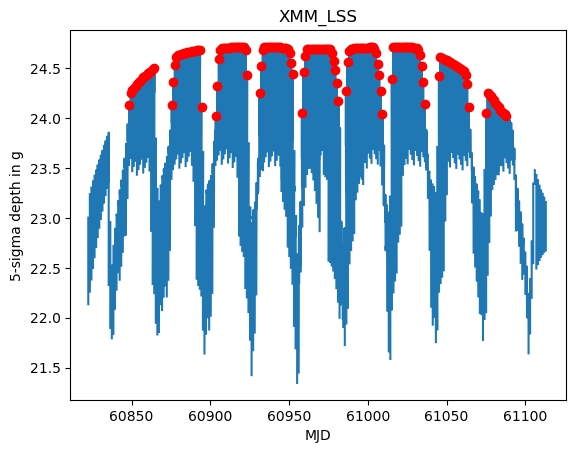

In [14]:
# Let's plot up where the final scheduled results actually landed:
final_mjd = np.unique(final_observations["mjd"])
depths = np.interp(final_mjd, ddf_grid["mjd"], ddf_grid["%s_m5_g" % ddf_name])

fig, ax = plt.subplots()

ax.plot(ddf_grid["mjd"], ddf_grid["%s_m5_g" % ddf_name])
ax.set_xlim([mjd_start+season_start_offset,mjd_start+season_end_offset])
ax.set_xlabel("MJD")
ax.set_title(ddf_name)
ax.set_ylabel('5-sigma depth in g')

ax.plot(final_mjd, depths, 'ro')

In [15]:
print('MJD midpoint: ',(final_mjd[-1] + final_mjd[0])/2.0)
print('season length: ',final_mjd[-1] - final_mjd[0])
print('MJD start: ',final_mjd[0])
print('MJD end:   ',final_mjd[-1])
print(' ')
print('number:',len(final_mjd))
print(final_mjd)

MJD midpoint:  60968.231249672164
season length:  239.60416661087947
MJD start:  60848.429166366725
MJD end:    61088.033332977604
 
number: 184
[60848.42916637 60849.42916637 60850.42916637 60851.42916637
 60852.42916637 60853.42916637 60854.42916637 60855.42916637
 60856.42916636 60857.42916636 60858.42916636 60859.42916636
 60860.42916636 60861.42916636 60862.42916636 60863.42916636
 60864.42916636 60875.42916636 60876.41874969 60877.41874969
 60878.41874969 60879.41874969 60880.41874969 60881.41874969
 60882.41874969 60883.41874969 60884.41874969 60885.41874969
 60886.41874969 60887.41874969 60888.41874969 60889.41874969
 60890.40833302 60891.40833302 60892.40833302 60893.40833302
 60894.42916636 60903.38749969 60904.30416635 60905.31458302
 60906.35624969 60907.37708302 60908.37708302 60909.37708302
 60910.37708302 60911.36666635 60912.36666635 60913.36666635
 60914.36666635 60915.35624968 60916.35624968 60917.35624968
 60918.35624968 60919.34583302 60920.34583302 60921.34583302
 

In [16]:
print('MJD midpoint: ',(final_mjd[-1] + final_mjd[0])/2.0)
print('season length: ',final_mjd[-1] - final_mjd[0])
print('MJD start: ',final_mjd[0])
print('MJD end:   ',final_mjd[-1])
print(' ')
cadence = len(final_mjd)//n_high_cadence
print('cadence: ',cadence)
n_at_cadence = len(final_mjd[::cadence])
print('number near',n_high_cadence,': ',n_at_cadence)
print(final_mjd[::cadence])

ncut = ((n_at_cadence - n_high_cadence) // 2)*cadence
if (ncut < 0): ncut = 1
print(' ')
out_mjd = final_mjd[ncut:-ncut:cadence]
print('forced to ',n_high_cadence,' :',len(out_mjd))
print('high season length:',out_mjd[-1]-out_mjd[0])
print(out_mjd)

MJD midpoint:  60968.231249672164
season length:  239.60416661087947
MJD start:  60848.429166366725
MJD end:    61088.033332977604
 
cadence:  4
number near 43 :  46
[60848.42916637 60852.42916637 60856.42916636 60860.42916636
 60864.42916636 60878.41874969 60882.41874969 60886.41874969
 60890.40833302 60894.42916636 60906.35624969 60910.37708302
 60914.36666635 60918.35624968 60922.37708302 60933.27291635
 60937.30416635 60941.29374968 60945.28333301 60949.29374968
 60958.08541634 60962.23124967 60966.22083301 60970.21041634
 60974.19999967 60978.26249967 60986.033333   60990.158333
 60994.14791633 60998.13749967 61002.127083   61006.19999966
 61015.03333299 61019.07499966 61023.06458299 61027.06458299
 61031.06458299 61035.06458299 61047.05416632 61051.05416632
 61055.05416632 61059.05416632 61063.05416632 61077.04374965
 61081.04374965 61085.03333298]
 
forced to  43  : 44
high season length: 228.61458328010485
[60852.42916637 60856.42916636 60860.42916636 60864.42916636
 60878.4187

In [17]:
extend_early = np.where(long_mjd < out_mjd[0])
early = long_mjd[extend_early]
nearly = len(early)
print('number of early points: ',nearly)
# 10, 50, and 80% points in the extension
early_indices = (np.array([0.1,0.5,0.8])*nearly).astype(int)
print('early_indices: ',early_indices)
print('appending: ',early[early_indices])
out_mjd = np.concatenate((early[early_indices], out_mjd))

extend_late = np.where(long_mjd > out_mjd[-1])
late = long_mjd[extend_late]
nlate = len(late)
print('number of late points: ',nlate)
# 10, 50, and 80% points in the extension (flipped to 0.2, 0.5, 0.9)
late_indices = (np.array([0.2,0.5,0.9])*nlate).astype(int)
print('late_indices: ',late_indices)
print('appending: ',late[late_indices])
out_mjd = np.concatenate((out_mjd,late[late_indices]))

print('total number of epochs should be ',n_high_cadence+6,': ',len(out_mjd))
print('final season length: ',out_mjd[-1] - out_mjd[0])
out_mjd

number of early points:  26
early_indices:  [ 2 13 20]
appending:  [60824.41874971 60835.42916637 60846.42916637]
number of late points:  25
late_indices:  [ 5 12 22]
appending:  [61087.03333298 61094.02291631 61111.01249964]
total number of epochs should be  49 :  50
final season length:  286.5937499332722


array([60824.41874971, 60835.42916637, 60846.42916637, 60852.42916637,
       60856.42916636, 60860.42916636, 60864.42916636, 60878.41874969,
       60882.41874969, 60886.41874969, 60890.40833302, 60894.42916636,
       60906.35624969, 60910.37708302, 60914.36666635, 60918.35624968,
       60922.37708302, 60933.27291635, 60937.30416635, 60941.29374968,
       60945.28333301, 60949.29374968, 60958.08541634, 60962.23124967,
       60966.22083301, 60970.21041634, 60974.19999967, 60978.26249967,
       60986.033333  , 60990.158333  , 60994.14791633, 60998.13749967,
       61002.127083  , 61006.19999966, 61015.03333299, 61019.07499966,
       61023.06458299, 61027.06458299, 61031.06458299, 61035.06458299,
       61047.05416632, 61051.05416632, 61055.05416632, 61059.05416632,
       61063.05416632, 61077.04374965, 61081.04374965, 61087.03333298,
       61094.02291631, 61111.01249964])

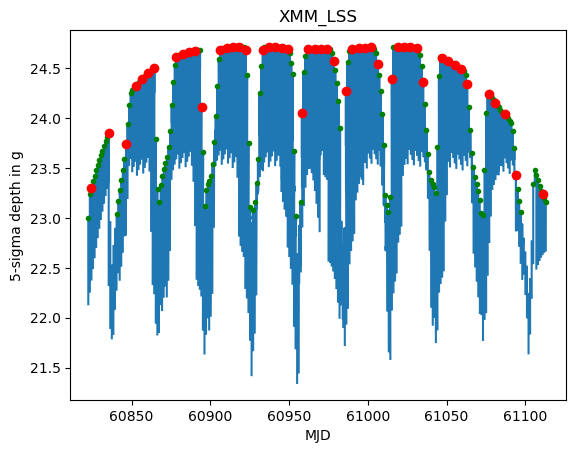

In [18]:
# Let's plot up where the final scheduled results actually landed:
depths = np.interp(long_mjd, ddf_grid["mjd"], ddf_grid["%s_m5_g" % ddf_name])
outdepths = np.interp(out_mjd, ddf_grid["mjd"], ddf_grid["%s_m5_g" % ddf_name])

fig, ax = plt.subplots()

ax.plot(ddf_grid["mjd"], ddf_grid["%s_m5_g" % ddf_name])
ax.set_xlim([mjd_start+season_start_offset,mjd_start+season_end_offset])
ax.set_xlabel("MJD")
ax.set_title(ddf_name)
ax.set_ylabel('5-sigma depth in g')

ax.plot(long_mjd, long_depths, 'g.')
ax.plot(out_mjd, outdepths, 'ro')
plt.savefig('uniform-longseason-%s.png' % ddf_name, dpi=150, bbox_inches='tight')
plt.show()